In [1]:
#libraries
import pandas as pd
import numpy as np
import os
import sys
import shutil
import glob
import joblib
import warnings
from datetime import date, datetime

from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import LeavePGroupsOut
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr
import scipy.stats as st

from nilearn import image as nli
from nilearn import plotting

#from mne.viz import plot_connectivity_circle
#from mne_connectivity.viz import plot_connectivity_circle


from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning


from scipy.stats import zscore as  zscore
from scipy.stats import bootstrap as bootstrap
import pickle

import copy

def my_statistic(x, y):
    #return pearsonr(x, y)[0]
    return mean_absolute_error(x, y)

##### Path and load data

In [2]:
path_ml_res = '/media/hcs-psy-narun/Alina/HCP_results/predicted_values_for_datasets_5/'
ml_results = {}
for key1, key2 in zip(['YA', 'A', 'D'], ['YA', 'A', 'DUD']):
    if key2=='DUD':
        ml_results[key1] = pd.read_csv(path_ml_res+'pred_vals_'+key2+'.csv', index_col=0).reindex(columns=['eNet_cort',
                                                                                                           'eNet_subc',
                                                                                                           'eNet_surf',
                                                                                                           'eNet_brainVol',
                                                                                                           'eNet_rest_PCA75',
                                                                                                           'eNet_eNet_set3',
                                                                                                           'y_obs'])
    else:
        ml_results[key1] = pd.read_csv(path_ml_res+'pred_vals_'+key2+'.csv', index_col=0).reindex(columns=['eNet_cort',
                                                                                                           'eNet_subc',
                                                                                                           'eNet_surf',
                                                                                                           'eNet_VolBrain',
                                                                                                           'eNet_rest_PCA75',
                                                                                                           'eNet_eNet_set3',
                                                                                                           'y_obs'])
    ml_results[key1].columns = ['cort', 'subc', 'surf', 'volBrain', 'rest_PCA', 'stack', 'origin_y']
    

In [3]:
pth = '/media/hcs-psy-narun/Alina/Lifespan_Projects_NonTask_Comparison/output_3dsets_stack_newREST/'

In [4]:
path_img_out = '/media/hcs-psy-narun/Alina/HCP_results/predicted_values_for_datasets_5/'

In [ ]:
# Load data (deserialize)
with open(pth+'Features.pkl', 'rb') as handle:
    features = pickle.load(handle)

In [ ]:
# Load data (deserialize)
with open(pth+'Outputs.pkl', 'rb') as handle:
    results = pickle.load(handle)

##### Calculate CI to plot (for correlation)

In [10]:
mat_cor = {}
mat_ci = {}
#mat_ci2 = {}

for mod in ml_results['D'].columns[:-1]:
    
    mat = pd.DataFrame(np.empty((3, 3,)) * np.nan, index = list(results.keys()), columns = list(results.keys()))
    mat_c = pd.DataFrame(np.empty((3, 3,)) * np.nan, index = list(results.keys()), columns = list(results.keys()))
    #mat_c2 = pd.DataFrame(np.empty((3, 3,)) * np.nan, index = list(results.keys()), columns = list(results.keys()))
    
    for key in list(results.keys()):

        for test in ['Test_1', 'Test_2']:
            
            boot = bootstrap(results[key][test]['y_pred'][['origin_y',mod]].T.values, my_statistic, 
                             vectorized=False, paired=True, 
                             n_resamples=5000, confidence_level=0.95, method='BCa', random_state=42)
            c_l, c_u = boot.confidence_interval
            vec = str('['+str(round(c_l, 2))+' - \n'+str(round(c_u, 2))+']')
            vec = vec.replace('0.', '.', 2)
            
            mat.loc[results[key][test]['dset'], key] = round(results[key][test]['performance'][mod]['mae'], 2)
            
            mat_c.loc[results[key][test]['dset'], key] =  vec
        
        #
        boot = bootstrap(ml_results[key][['origin_y', mod]].T.values, my_statistic, 
                         vectorized=False, paired=True, 
                         n_resamples=5000, confidence_level=0.95, method='BCa', random_state=42)
        c_l, c_u = boot.confidence_interval
        vec = str('['+str(round(c_l, 2))+' - \n'+str(round(c_u, 2))+']')
        vec = vec.replace('0.', '.', 2)

        mat.loc[key, key] = round(mean_absolute_error(ml_results[key]['origin_y'].values,ml_results[key][mod].values), 2)
        
        mat_c.loc[key, key] = vec
        
        
    mat_cor[mod] = mat
    mat_ci[mod] = mat_c

In [11]:
#formatting ci to specific form
mat_ci2 = {}

for mod in mat_ci.keys():
    
    mtc2 = pd.DataFrame([], index = mat_ci[mod].index, columns = mat_ci[mod].index)
    
    for i in mat_ci[mod].index:
        for j in mat_ci[mod].columns:
            
            string = str(mat_cor[mod].loc[i,j])+'\n'+str(mat_ci[mod].loc[i,j])
            string = string.replace("- \n.", "- .")
            string = string.replace("0.", ".")
            
            mtc2.loc[i,j] = string
            
    mat_ci2[mod] = mtc2

##### Average generalizability (correlation)

In [12]:
ordr = pd.Series(dtype=float)
for key in mat_cor.keys():
    ordr[key] = np.mean(mat_cor[key].values.ravel())
order = pd.DataFrame({'mean':ordr, 'label':['Cortical Thickness', 
                                            'Subcortical Volume', 
                                            'Cortical Area', 
                                            'Total Brain Volume', 
                                            'Resting State FC',
                                            'Stacked: Non Task' ]}, index = ordr.index)
order = order.sort_values(by='mean',ascending=True)
display(order)

,mean,label
rest_PCA,0.777778,Resting State FC
volBrain,0.781111,Total Brain Volume
stack,0.781111,Stacked: Non Task
subc,0.790000,Subcortical Volume
surf,0.795556,Cortical Area
cort,0.801111,Cortical Thickness


In [13]:
within_dset_cor_genrl = {}
between_dset_cor_genrl = {}

within_dset_cor_sdev_genrl = {}
between_dset_cor_sdev_genrl = {}

for mod in mat_cor.keys():
    
    mtrx = copy.deepcopy(mat_cor[mod])
    
    inr = [] #inner
    onr = [] #outer
    for k in range(len(mtrx.index)):
        inr += [mtrx.iloc[k,k]]
        mtrx.iloc[k,k] = np.nan
    onr = mtrx.values.ravel()
    onr = onr[~np.isnan(onr)]

    within_dset_cor_genrl[mod] = np.mean(inr)
    between_dset_cor_genrl[mod] = np.mean(onr)
    
    within_dset_cor_sdev_genrl[mod] = np.std(inr)
    between_dset_cor_sdev_genrl[mod] = np.std(onr)
    
df_mean_gen_cor = pd.DataFrame({'within datasets':within_dset_cor_genrl,
                                'between datasets':between_dset_cor_genrl,
                                'within datasets SD':within_dset_cor_sdev_genrl,
                                'between datasets SD':between_dset_cor_sdev_genrl})

In [14]:
df_mean_gen_cor.sort_values(by='within datasets', ascending=True)

,within datasets,between datasets,within datasets SD,between datasets SD
stack,0.740000,0.801667,0.024495,0.033871
rest_PCA,0.760000,0.786667,0.021602,0.013744
volBrain,0.783333,0.780000,0.016997,0.015275
cort,0.786667,0.808333,0.016997,0.008975
surf,0.786667,0.800000,0.012472,0.010000
subc,0.790000,0.790000,0.016330,0.011547


In [15]:
df_mean_gen_cor.sort_values(by='within datasets', ascending=False).iloc[1:].mean()

within datasets        0.771333
between datasets       0.795333
within datasets SD     0.018513
between datasets SD    0.016373
dtype: float64

##### Plotting

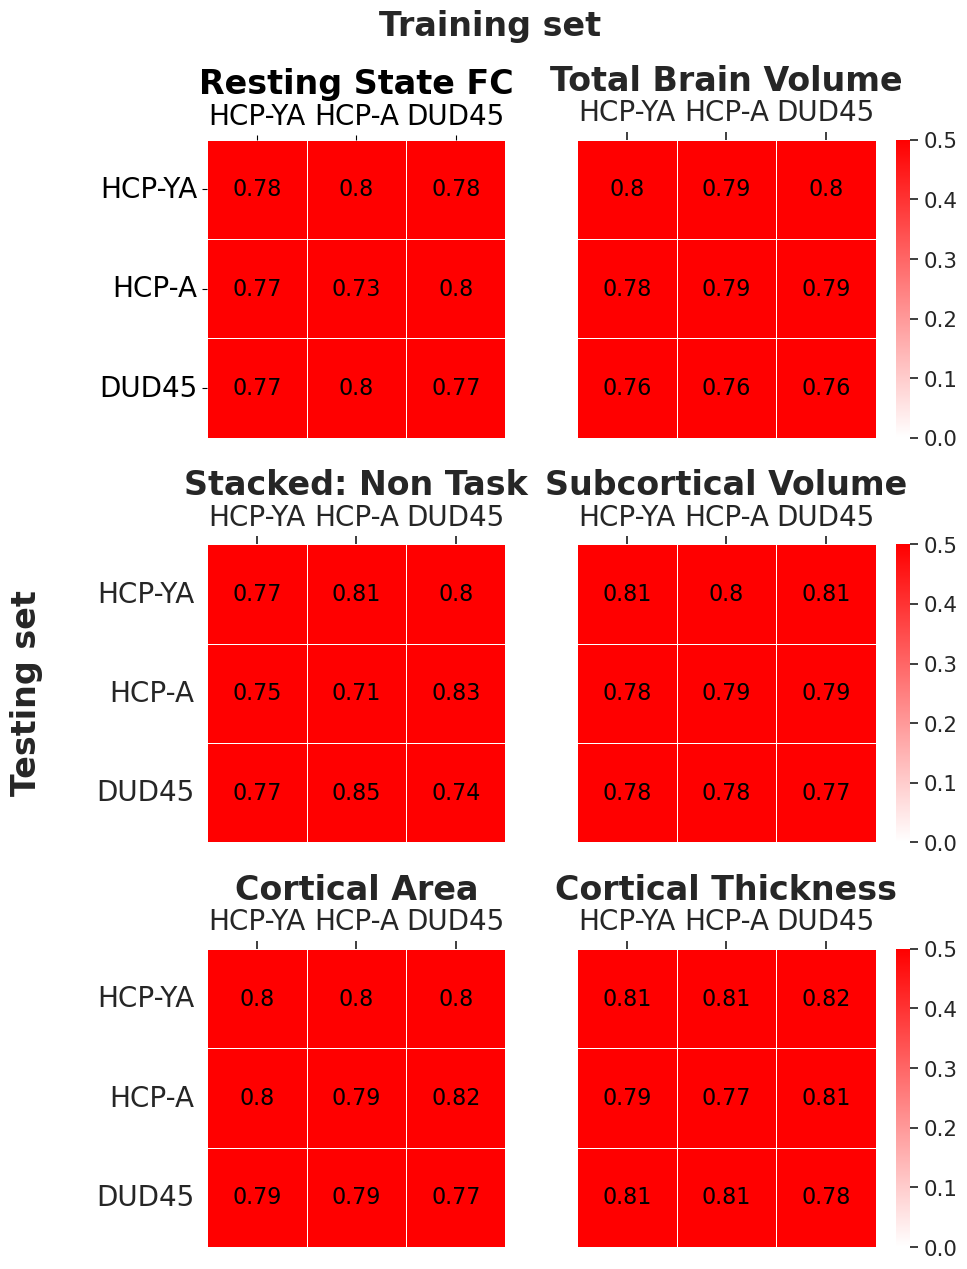

In [16]:
import matplotlib
from matplotlib.colors import LinearSegmentedColormap

ax_label = ['HCP-YA', 'HCP-A', 'DUD45']
cmap = LinearSegmentedColormap.from_list('name', ['white', 'red'])#sns.diverging_palette(-10, 20, as_cmap=True)


fig = plt.figure(figsize=(10,13))
i=1
for mod in order.index:
    nms = order.loc[mod,'label']
    
    plt.subplot(3, 2, i)
    
    data = copy.deepcopy(mat_cor[mod])
    data.index = ax_label
    data.columns = ax_label
    if i%2 != 0 :
        cbar = False
    else:
        cbar = True
    ax = sns.heatmap(data,  cbar=cbar, annot=True,#mat_ci[mod],
                     cmap=cmap,#'afmhot_r', 
                     vmin=0, vmax=0.5, 
                     linewidth=.5, fmt = '', 
                     annot_kws={"fontsize":16, 'color':'black'}, square=True)
     
    sns.set(font_scale=1.4)
    ax.xaxis.tick_top()
    plt.xticks(rotation=0, fontsize=20)
    
    plt.title(nms, fontsize=24, fontweight="bold")
    
    if i%2 != 0 :
        plt.yticks(rotation=0, fontsize=20)
    else:
        plt.yticks([],rotation=0, fontsize=20)
    
    i+=1
    
fig.supxlabel('Training set', y=1, fontsize=24, fontweight="bold")
fig.supylabel('Testing set', fontsize=24, fontweight="bold")
fig.tight_layout()

#plt.savefig(path_img_out+'generalizability2_cor_plot_image.svg',bbox_inches='tight')

plt.show()

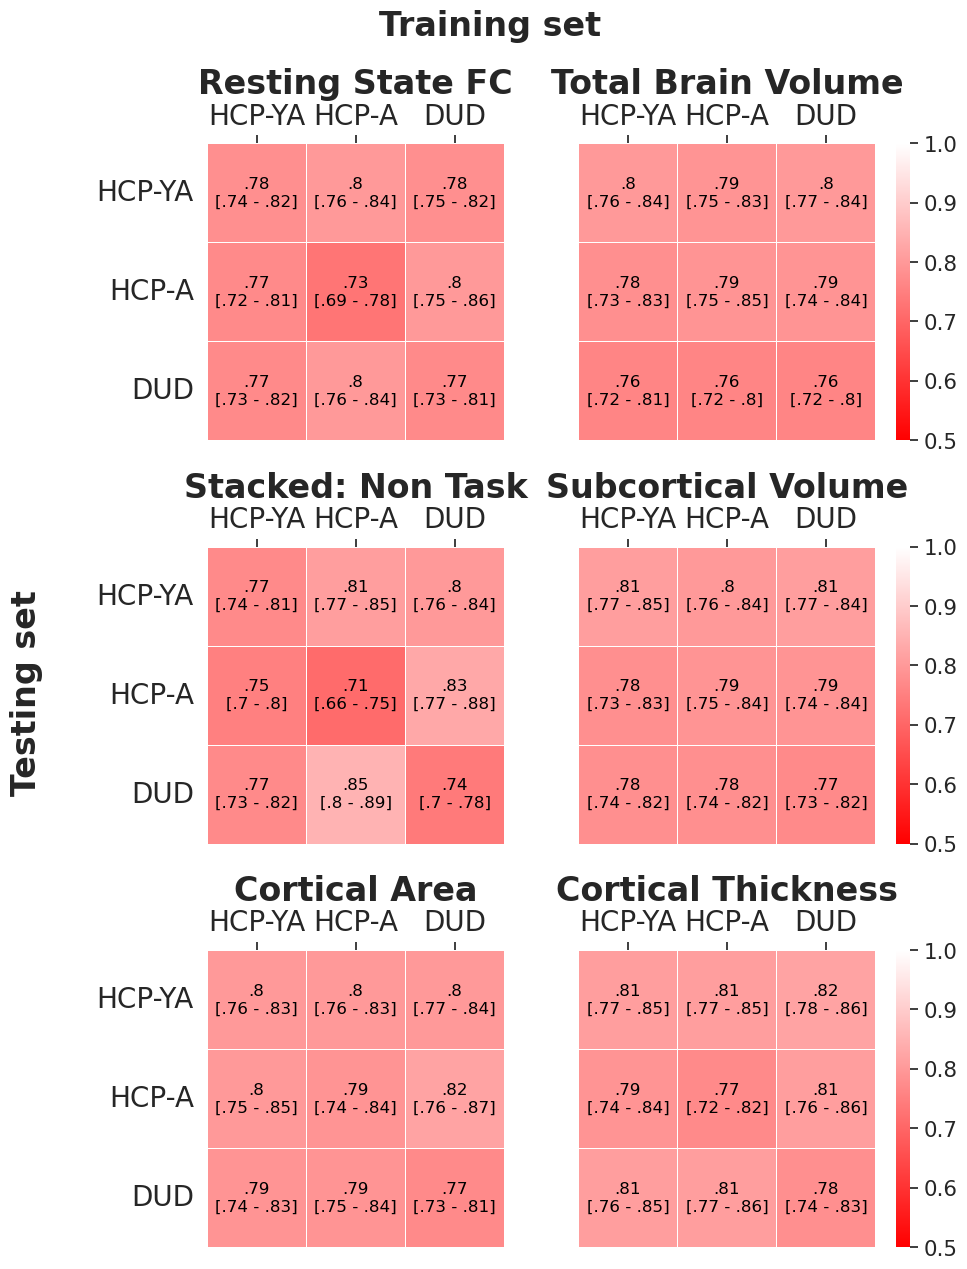

In [22]:
import matplotlib
from matplotlib.colors import LinearSegmentedColormap

ax_label = ['HCP-YA', 'HCP-A', 'DUD']
cmap = LinearSegmentedColormap.from_list('name', ['red','white'])#sns.diverging_palette(-10, 20, as_cmap=True)


fig = plt.figure(figsize=(10,13))
i=1
for mod in order.index:
    nms = order.loc[mod,'label']
    
    plt.subplot(3, 2, i)
    
    data = copy.deepcopy(mat_cor[mod])
    data.index = ax_label
    data.columns = ax_label
    if i%2 != 0 :
        cbar = False
    else:
        cbar = True
    ax = sns.heatmap(data, annot=mat_ci2[mod], cbar=cbar,
                     cmap=cmap,#'afmhot_r', 
                     vmin=0.5, vmax=1, 
                     linewidth=.5, fmt = '', 
                     annot_kws={"fontsize":12, 'color':'black'}, square=True)
     
    sns.set(font_scale=1.4)
    ax.xaxis.tick_top()
    plt.xticks(rotation=0, fontsize=20)
    
    plt.title(nms, fontsize=24, fontweight="bold")
    
    if i%2 != 0 :
        plt.yticks(rotation=0, fontsize=20)
    else:
        plt.yticks([],rotation=0, fontsize=20)
    
    i+=1
    
fig.supxlabel('Training set', y=1, fontsize=24, fontweight="bold")
fig.supylabel('Testing set', fontsize=24, fontweight="bold")
fig.tight_layout()

plt.savefig(path_img_out+'generalizability_plot_mae_image6.svg',bbox_inches='tight')
plt.savefig(path_img_out+'generalizability_plot_mae_image6.png',bbox_inches='tight')

plt.show()